In [2]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [4]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.01           # rate E  -> Q
tA    = 0.01           # rate A  -> Q
tIa   = 0.01           # rate Ia -> Q
tIs   = 0.5          # rate Is -> Q, fast testing for the infected 



# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([20, 20])
A0  = np.array([20, 20])
Ia0 = np.array([10, 10])     
Is0 = np.array([10, 10])     
Q0  = np.array([10, 10])
R0  = np.array([0, 0])     
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAIRQ_sto_traj.npy', data_array)

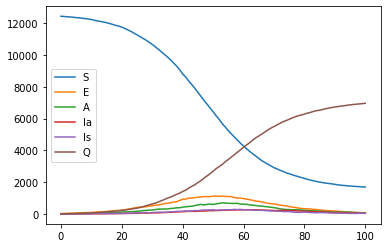

In [5]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')
plt.plot(data_array[:, 5*M], label='Q')

plt.legend()
plt.show()

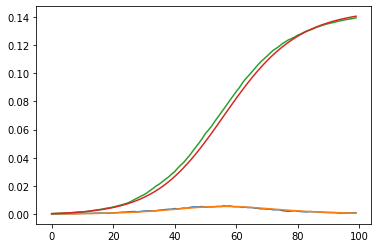

In [10]:
# load the data and rescale to intensive variables 
x = np.load('SEAIRQ_sto_traj.npy').astype('float')
x = x/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, False, False, True, True]), M)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
det_model = pyross.deterministic.SEAIRQ(parameters, int(M), fi)
xm, full_cov = estimator.obtain_full_mean_cov(x0, Tf, Nf, det_model, contactMatrix)
full_cov = full_cov.todense()
plt.plot(x[1:, 4*M], label='Is')
plt.plot(xm[:, 4*M])
plt.plot(x[1:,5*M], label='Q')
plt.plot(xm[:, 5*M])
plt.show()

In [11]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-779.544257235952
2.430790901184082


In [12]:
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm, can use as a lower bound for parameters 

alpha_g = 0.2
alpha_bounds = (0.1, 0.5) # large uncertainty on the fraction of asymptomatic people 
# the upper bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.07
beta_bounds = (eps, 0.1) # large uncertainty on beta (e.g. during a lockdown, beta can be very low)

gIa_g = 0.2
gIa_bounds = (eps, 0.5) # large uncertainty on how quickly asymptomatic people recover 

gIs_g = 0.145
gIs_bounds = (0.13, 0.15) # tight bounds on gIs (can come from clinical data)

gE_g = 0.22
gE_bounds = (0.15, 0.25) # tight bounds on the exit rate from the exposed class 

gA_g = 0.3 
gA_bounds = (0.25, 0.35) # tight bounds on the exit rate from the activated class 

fsa_g = 0.8 # assume we know this precisely 


# guesses for the unknown initial conditions 
E0_g = (E0+5)/N 
bounds_for_E = [(1/N, 100/N)]*M #large uncertainty 
A0_g = (A0+5)/N 
bounds_for_A = [(1/N, 100/N)]*M #large uncertainty 
Ia0_g = Ia0/N
bounds_for_Ia = [(1/N, 100/N)]*M #large uncertainty 
S0_g = (S0-10)/N
bounds_for_S = [(fi[i]-320/N-Q0[i]/N, fi[i]-0.2/N) for i in range(M)] # consistent with other guesses 

# as a result of the van kampen system size expansion, Is0 does not have to be the same as the true value
Is0_g = Is0/N 
bounds_for_Is = [(5/N, 15/N)]*M 
Q0_g = Q0/N 
bounds_for_Q = [(5/N, 15/N)]*M 

# optimisation parameters 
ftol = 1e-3 # the relative tol in (-logp)  

# set up bounds 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, gA_bounds, 
                    *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is, *bounds_for_Q])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Q0_g])
params = estimator.latent_inference(guess, obs, fltr, Tf, Nf, contactMatrix, 
                                    bounds, verbose=True, niter=4, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

parameters: [0.15401995 0.03785995 0.10808588 0.13810299 0.18781397 0.27700998]
parameters: [0.15371196 0.03740494 0.10749767 0.13806303 0.18777051 0.27688671]
parameters: [0.15111113 0.0334231  0.10257016 0.13774253 0.18735465 0.27587308]
parameters: [0.14947253 0.03060788 0.09952635 0.13756553 0.18720733 0.27518531]
parameters: [0.1480917  0.02779357 0.09701643 0.13745434 0.18721345 0.27468389]
parameters: [0.14707581 0.0252905  0.09522026 0.13742032 0.18734447 0.27435081]
parameters: [0.14618503 0.0227286  0.09366731 0.13744125 0.18757659 0.27406573]
parameters: [0.14551551 0.02024686 0.09256795 0.13750533 0.18790091 0.27389409]
parameters: [0.14514812 0.01868688 0.09198267 0.13755132 0.18813503 0.27380926]
parameters: [0.14556042 0.01837416 0.0929041  0.13768921 0.18838797 0.27409675]
parameters: [0.14698283 0.01800818 0.09599211 0.13810385 0.18908264 0.27502454]
parameters: [0.14958798 0.01777705 0.1016165  0.13887298 0.19028815 0.27671276]
parameters: [0.15213999 0.01799307 0.107

In [14]:
# save the parameters 
np.save('SEAIRQ_param.npy', params)

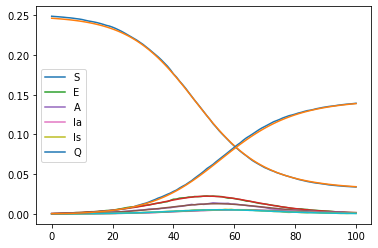

In [18]:
params = np.load('SEAIRQ_param.npy')
parameters = estimator.make_params_dict(params[:6])
estimator.set_params(parameters)
x0 = params[6:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='A')
plt.plot(x_det[:, 2*M])
plt.plot(x[:,3*M], label='Ia')
plt.plot(x_det[:, 3*M])
plt.plot(x[:,4*M], label='Is')
plt.plot(x_det[:, 4*M])
plt.plot(x[:,5*M], label='Q')
plt.plot(x_det[:, 5*M])
plt.legend()
plt.show()

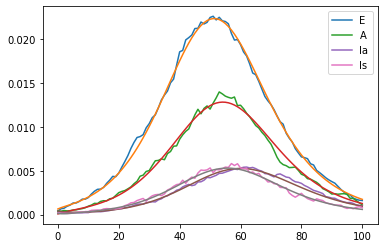

In [19]:
# only plot the infected 
plt.plot(x[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='A')
plt.plot(x_det[:, 2*M])
plt.plot(x[:,3*M], label='Ia')
plt.plot(x_det[:, 3*M])
plt.plot(x[:,4*M], label='Is')
plt.plot(x_det[:, 4*M])
plt.legend()
plt.show()